# 投资者情绪专题
在短暂的学习生涯中,窥见了学术前沿中一些令人兴奋的领域...这使我如此渴望接触更大的世界,在研究中"讲好中国故事"!
- 结果表明,媒体情绪会对投资者情绪产生显著的影响;但经过交易日加权处理后这种影响被弱化了.

## 1.数据准备

In [1]:
import sys
import os
import cudf  #CUDA计算
import pandas as pd
import numpy as np

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')
from loader.findata_loader import Loader
from utils.sql import DB

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


### 媒体情绪数据

In [2]:
def extract_pdate_mediasent() -> cudf.DataFrame:
    """
    提取推文中的情绪,自然日期
    :return:
    """
    # 提取
    pd.options.mode.chained_assignment = None  #忽略警告
    df_select = pd.read_sql(
            "SELECT id,p_date, title_neg, cover_neg, biz FROM WECAHT_DATA.articles_tag "
            "WHERE mov=10 AND biz in ('MjM5MzMwNjM0MA==','MjM5NzQ5MTkyMA==','MjY2NzgwMjU0MA==','MjY2NzgwMjU0MA==')",
            con=DB().ENGINE,
            parse_dates=["p_date"])

    # 筛选
    df_select['p_date'] = df_select['p_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_select = df_select.query("p_date>=20140101")

    # 阈值处理
    df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
    df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)

    # 每日情绪
    df_select['day_article'] = df_select.groupby('p_date')['id'].transform('count')

    df_select['tex_neg'] = df_select['title_flag'] / df_select['day_article']
    df_select['img_neg'] = df_select['cover_flag'] / df_select['day_article']

    # 时间序列
    df_select = df_select.groupby(['p_date', ], as_index=False).first()
    # 筛选
    return cudf.from_pandas(df_select[['p_date', 'img_neg', 'tex_neg']]).set_index('p_date').sort_index().reset_index()


def extract_tdate_mediasent() -> cudf.DataFrame:
    """
    按照交易日返回媒体情绪
    :return:
    """
    return Loader().get_time_series()[['img_neg', 'tex_neg', ]].sort_index().reset_index().dropna(axis=0)


extract_pdate_mediasent()

,p_date,img_neg,tex_neg
0,20140101,0.0,0.000000
1,20140102,0.0,0.000000
2,20140103,0.0,0.333333
3,20140104,0.0,0.000000
4,20140105,0.0,0.000000
...,...,...,...
3069,20220623,0.0,0.000000
3070,20220624,0.0,0.142857
3071,20220625,0.0,0.000000
3072,20220626,0.0,0.000000


In [3]:
extract_tdate_mediasent()

,trade_date,img_neg,tex_neg
0,20140102,0.000000,0.000000
1,20140103,0.000000,0.333333
2,20140106,0.285714,0.142857
3,20140107,0.000000,0.333333
4,20140108,0.333333,0.000000
...,...,...,...
2090,20220621,0.238095,0.285714
2091,20220622,0.227273,0.227273
2092,20220623,0.363636,0.363636
2093,20220624,0.200000,0.300000


### 股吧情绪数据

In [4]:
def extract_pdate_forumsent() -> cudf.DataFrame:
    """
    股吧情绪,自然日期
    :return:
    """

    df_forum = (
            cudf.read_parquet(
                    DATASETS_PATH + 'FORUM_SENT_TRANS.parquet',
                    columns=['PostDate', 'Stockcode', 'PostSource', 'PositiveSentIndexA', 'PositiveSentIndexB',
                             'PositivePosts', 'NeutralPosts', 'NegativePosts',
                             'TotalPosts', 'AvgReadings', 'AvgComments', 'AvgThumbUps',
                             'AvgUserBarAge'])
            .rename(columns={'TotalPosts': 'CumPosts', 'PostDate': 'p_date'})
            .astype(dtype={'PositivePosts': 'float64', 'NeutralPosts': 'float64', 'NegativePosts': 'float64'})
            .query("(p_date>=20140101) & (PostSource==1)")
    )

    return df_forum.set_index(['p_date', 'Stockcode']).sort_index().reset_index()


#
extract_pdate_forumsent()

,p_date,Stockcode,PostSource,PositiveSentIndexA,PositiveSentIndexB,PositivePosts,NeutralPosts,NegativePosts,CumPosts,AvgReadings,AvgComments,AvgThumbUps,AvgUserBarAge
0,20140101,000030.SZ,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
1,20140101,000030.SZ,1,<NA>,<NA>,<NA>,0.0,<NA>,0,<NA>,<NA>,<NA>,<NA>
2,20140101,000034.SZ,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
3,20140101,000034.SZ,1,<NA>,<NA>,<NA>,0.0,<NA>,0,<NA>,<NA>,<NA>,<NA>
4,20140101,000043.SZ,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7510755,20211016,900948.SH,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
7510756,20211016,900952.SH,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
7510757,20211016,900953.SH,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>
7510758,20211016,900955.SH,1,<NA>,<NA>,0.0,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>


### 指数面板数据

In [5]:
def extract_index_price() -> cudf.DataFrame:
    """
    提取指数价格数据
    :return:
    """
    df_basic = (cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_BASIC_WUGUI.parquet', columns=['close'])
                .query("trade_date>=20131231").reset_index())
    df_basic['close_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['close'].shift(1)
    df_basic['close_chg'] = 100 * ((df_basic['close'] / df_basic['close_l1']) - 1)
    df_basic['time'] = df_basic.groupby(by=['ts_code'])['trade_date'].rank()
    return df_basic.set_index(['trade_date', 'ts_code']).sort_index().reset_index()


extract_index_price()

,trade_date,ts_code,close,close_l1,close_chg,time
0,20131231,000001.SH,2115.9800,<NA>,<NA>,1.0
1,20131231,000010.SH,5040.2700,<NA>,<NA>,1.0
2,20131231,000015.SH,1681.4600,<NA>,<NA>,1.0
3,20131231,000016.SH,1574.7800,<NA>,<NA>,1.0
4,20131231,000300.SH,2330.0300,<NA>,<NA>,1.0
...,...,...,...,...,...,...
28251,20221209,000985.SH,4973.3481,4947.6296,0.519814579,2172.0
28252,20221209,399001.SZ,11501.5800,11389.79,0.981493074,2175.0
28253,20221209,399005.SZ,7674.1500,7610.6,0.835019578,2175.0
28254,20221209,399006.SZ,2420.6300,2411.81,0.365700449,2175.0


### 日期映射规则数据
映射自然日期到交易日期

In [6]:
def extract_map_date() -> cudf.DataFrame:
    """
    提取映射规则
    :return:
    """
    df_mapdate = pd.read_sql_table('map_date', DB().ENGINE, 'FIN_BASIC', parse_dates=['nature_date', 'map_l0'])[
        ['nature_date', 'map_l0', 'map_l1']]
    df_mapdate['nature_date'] = df_mapdate['nature_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_mapdate.dropna(axis=0, subset=['map_l0', 'map_l1'], inplace=True)
    df_mapdate['map_l0'] = df_mapdate['map_l0'].dt.strftime('%Y%m%d').astype('uint32')
    df_mapdate['map_l1'] = df_mapdate['map_l1'].dt.strftime('%Y%m%d').astype('uint32')
    return cudf.from_pandas(df_mapdate.rename(columns={'nature_date': 'p_date', 'map_l0': 'trade_date', 'map_l1': 'trade_date_l1'}))


extract_map_date()

,p_date,trade_date,trade_date_l1
0,20140101,20140102,20140102
1,20140102,20140102,20140103
2,20140103,20140103,20140106
3,20140104,20140106,20140106
4,20140105,20140106,20140106
...,...,...,...
3234,20221109,20221109,20221110
3235,20221110,20221110,20221111
3236,20221111,20221111,20221114
3237,20221112,20221114,20221114


## 2.投资者情绪指标计算

### 参数区
计算加权影响力,参数为影响力系数,点赞评论阅读

In [7]:
# 5311 5%A 10%B
# 1000 9100  X
# 1000 X

# pdate
# A, B, C, D = 0.6, 0.2, 0.1, 0.1
A, B, C, D = 1.0, 0.0, 0.0, 0.0
# A, B, C, D = 0.0, 1.0, 0.0, 0.0

# tdate
A2, B2, C2, D2 = 0.6, 0.2, 0.1, 0.1

### 发布日情绪
在数据处理上,无论是否填充0 , 还是删除缺失数据,均显著

In [8]:
def cal_investor_sentiment_pdate() -> pd.DataFrame:
    """
    从论坛面板原始数据中,合并映射日期,并进行聚合
    :return:合并了媒体情绪和投资者情绪
    """

    # 映射,多了一列trade_date
    df_forum = cudf.merge(extract_pdate_forumsent(), extract_map_date(), on='p_date', how='left')

    # 去重
    df_forum = df_forum.groupby(['p_date', 'Stockcode']).first().reset_index()

    # 计算每日总量
    df_forum.eval(
            """
            TotalPosts = PositivePosts+NeutralPosts+NegativePosts
            TotalReadings = AvgReadings*TotalPosts
            TotalComments = AvgComments*TotalPosts
            TotalThumbUps = AvgThumbUps*TotalPosts
            """, inplace=True)

    # 汇总每天的注意力数据,以计算每只股票的权重因子
    for col in ['AvgUserBarAge',
                'TotalPosts', 'TotalReadings', 'TotalComments', 'TotalThumbUps',
                'PositivePosts', 'NeutralPosts', 'NegativePosts']:
        # 年龄
        if col == 'AvgUserBarAge': df_forum['day' + col] = df_forum.groupby(['p_date'])[col].transform('mean')
        # 注意力 + 帖子
        else: df_forum['day' + col] = df_forum.groupby(['p_date'])[col].transform('sum')

    # 计算权重因子
    df_forum.eval(
            f"""
            factorPositiveSentIndexA = PositiveSentIndexA * ({A}*(TotalPosts/dayTotalPosts)+ {B}*(TotalReadings/dayTotalReadings)+{C}*(TotalComments/dayTotalComments) + {D}*(TotalThumbUps/dayTotalThumbUps))
            factorPositiveSentIndexB = PositiveSentIndexB * ({A}*(TotalPosts/dayTotalPosts)+ {B}*(TotalReadings/dayTotalReadings)+{C}*(TotalComments/dayTotalComments) + {D}*(TotalThumbUps/dayTotalThumbUps))

            dayPosRatio = dayPositivePosts/dayTotalPosts
            dayNeuRatio = dayNeutralPosts/dayTotalPosts
            dayNegRatio = dayNegativePosts/dayTotalPosts

            dayNegDummy = dayNegativePosts > dayPositivePosts
            dayPosDummy = dayNegativePosts < dayPositivePosts

            """, inplace=True)
    # 布尔转换
    df_forum['dayNegDummy'] = 1 * df_forum['dayNegDummy']
    df_forum['dayPosDummy'] = 1 * df_forum['dayPosDummy']

    # 计算每日情绪
    df_forum['SentIndexA'] = df_forum.groupby(['p_date'])['factorPositiveSentIndexA'].transform('sum')
    df_forum['SentIndexB'] = df_forum.groupby(['p_date'])['factorPositiveSentIndexB'].transform('sum')

    # 时间序列数据
    df_forum = df_forum.groupby(['p_date']).first()[
        ['SentIndexA', 'SentIndexB',
         'dayAvgUserBarAge',
         'dayTotalPosts', 'dayTotalReadings', 'dayTotalComments', 'dayTotalThumbUps',
         'dayPositivePosts', 'dayNeutralPosts', 'dayNegativePosts',
         'dayPosRatio', 'dayNeuRatio', 'dayNegRatio',
         'dayNegDummy', 'dayPosDummy'
         ]].reset_index()

    # 方便Stata命名
    df_forum.columns = ['p_date',
                        'IndexA', 'IndexB',
                        'Age', 'Posts', 'Readings', 'Comments', 'ThumbUps',
                        'PosPosts', 'NeuPosts', 'NegPosts',
                        'PosRatio', 'NeuRatio', 'NegRatio',
                        'NegDummy', 'PosDummy']

    # 合并媒体情绪
    df_merge = cudf.merge(extract_pdate_mediasent(), df_forum, on='p_date', how='left')

    # 筛选
    return (
            df_merge.set_index('p_date').sort_index().reset_index().to_pandas()
            .astype(dtype={'p_date': 'str'})
    )


df_ols_pdate = cal_investor_sentiment_pdate()
df_ols_pdate

,p_date,img_neg,tex_neg,IndexA,IndexB,Age,Posts,Readings,Comments,ThumbUps,PosPosts,NeuPosts,NegPosts,PosRatio,NeuRatio,NegRatio,NegDummy,PosDummy
0,20140101,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
1,20140102,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
2,20140103,0.0,0.333333,0.0,0.0,0.095,2.0,107379.0,342.0,2.0,1.0,0.0,1.0,0.5,0.0,0.5,0.0,0.0
3,20140104,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
4,20140105,0.0,0.000000,NaN,NaN,0.000,1.0,9694.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,20220623,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,20220624,0.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3071,20220625,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,20220626,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 交易日情绪

In [9]:
def cal_investor_sentiment_tdate() -> pd.DataFrame:
    """
    :return:合并了媒体情绪和投资者情绪, 按照交易日聚合
    """

    # 映射,多了一列trade_date
    df_forum = cudf.merge(extract_pdate_forumsent(), extract_map_date(), on='p_date', how='left')

    # 去重
    df_forum = df_forum.groupby(['p_date', 'Stockcode']).first().reset_index()

    # 计算每日总量
    df_forum.eval(
            """
            TotalPosts = PositivePosts+NeutralPosts+NegativePosts
            TotalReadings = AvgReadings*TotalPosts
            TotalComments = AvgComments*TotalPosts
            TotalThumbUps = AvgThumbUps*TotalPosts
            """, inplace=True)

    # 汇总每天的注意力数据 加总
    for col in ['TotalPosts', 'TotalReadings', 'TotalComments', 'TotalThumbUps',
                'PositivePosts', 'NeutralPosts', 'NegativePosts']:
        df_forum['day' + col] = df_forum.groupby('trade_date')[col].transform('sum')

    # 计算每日情绪 平均
    df_forum['SentIndexA'] = df_forum.groupby(['trade_date'])['PositiveSentIndexA'].transform('mean')
    df_forum['SentIndexB'] = df_forum.groupby(['trade_date'])['PositiveSentIndexB'].transform('mean')

    # 时间序列数据

    df_forum = df_forum.groupby(['trade_date']).first()[
        ['SentIndexA', 'SentIndexB',
         'dayTotalPosts', 'dayTotalReadings', 'dayTotalComments', 'dayTotalThumbUps',
         'dayPositivePosts', 'dayNeutralPosts', 'dayNegativePosts',
         ]].reset_index()

    # 方便Stata命名
    df_forum.columns = ['trade_date',
                        'IndexA', 'IndexB',
                        'Posts', 'Readings', 'Comments', 'ThumbUps',
                        'PosPosts', 'NeuPosts', 'NegPosts',
                        ]
    # 重新计算情绪
    df_forum.eval(
            """
            IndexA = (PosPosts-NegPosts)/(PosPosts+NegPosts)
            IndexB = (1.0+PosPosts)/(1.0+NegPosts)
            PosRatio = PosPosts/Posts
            NeuRatio = NeuPosts/Posts
            NegRatio = NegPosts/Posts
            """, inplace=True)
    df_forum['IndexB'] = np.log(df_forum['IndexB'])

    # 导出
    df_forum.set_index(['trade_date']).sort_index().to_parquet(DATASETS_PATH + 'FORUM_SENT_TDATE_CSMAR.parquet')

    # 合并媒体情绪
    df_merge = cudf.merge(extract_tdate_mediasent(), df_forum, on='trade_date', how='right').sort_values('trade_date')

    return df_merge.to_pandas().astype(dtype={'trade_date': 'str'})


df_ols_tdate = cal_investor_sentiment_tdate()
df_ols_tdate

,trade_date,IndexA,IndexB,Posts,Readings,Comments,ThumbUps,PosPosts,NeuPosts,NegPosts,PosRatio,NeuRatio,NegRatio,img_neg,tex_neg
1752,20140102,NaN,0.000000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000
1753,20140103,0.000000,0.000000,2.0,107379.00,342.00,2.00,1.0,0.0,1.0,0.500000,0.000000,0.500000,0.000000,0.333333
1754,20140106,0.000000,0.000000,2.0,22652.00,47.00,0.00,1.0,0.0,1.0,0.500000,0.000000,0.500000,0.285714,0.142857
1755,20140107,NaN,0.000000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.333333
1756,20140108,NaN,0.000000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,20211012,-0.229368,-0.467035,120497.0,26442508.27,273224.20,172338.87,42169.0,11057.0,67271.0,0.349959,0.091762,0.558279,0.238095,0.285714
100,20211013,-0.226023,-0.459981,123178.0,27651587.71,288526.17,177561.46,43256.0,11402.0,68520.0,0.351167,0.092565,0.556268,0.473684,0.210526
101,20211014,-0.188129,-0.380788,135718.0,30212375.19,303991.93,188185.02,50036.0,12457.0,73225.0,0.368676,0.091786,0.539538,0.250000,0.150000
102,20211015,-0.268408,-0.550281,96804.0,19564087.44,218796.43,121423.77,32133.0,8960.0,55711.0,0.331939,0.092558,0.575503,0.190476,0.142857


## 3.媒体情绪对投资者情绪的影响

### 描述性统计

In [10]:

def cal_sum_table(df_origin: pd.DataFrame) -> pd.DataFrame:
    """
    描述性统计专用
    :return: 按照年份聚合
    """

    df_sum = df_origin.copy()
    df_sum['year'] = (df_sum['p_date'].str[:-4]).astype('int')

    # 聚合年份
    df_sum = pd.concat([df_sum.groupby('year')[['Posts', 'Readings', 'Comments', 'ThumbUps']].sum(True),
                        df_sum.groupby('year')[['Age', 'NegRatio', 'NeuRatio', 'PosRatio']].mean(True)], axis=1).query(
            "year<=2021")

    # 计算增长率
    df_sum = df_sum.join(((df_sum / df_sum.shift(1)) - 1) * 100, rsuffix='Yoy').fillna(0).reset_index()
    return df_sum


df_ols_pdate_sum = cal_sum_table(df_ols_pdate)
df_ols_pdate_sum

,year,Posts,Readings,Comments,ThumbUps,Age,NegRatio,NeuRatio,PosRatio,PostsYoy,ReadingsYoy,CommentsYoy,ThumbUpsYoy,AgeYoy,NegRatioYoy,NeuRatioYoy,PosRatioYoy
0,2014,355.0,1.665808e+07,3.069700e+04,1.498000e+03,1.470309,0.311025,0.113472,0.575504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015,1122.0,1.389634e+08,1.593680e+05,1.710599e+04,1.922575,0.357825,0.075882,0.566294,216.056338,734.210227,419.164707,1041.921896,30.759894,15.047015,-33.127130,-1.600353
2,2016,2425.0,1.058315e+08,1.416120e+05,1.601096e+04,2.553694,0.345015,0.087464,0.567521,116.131907,-23.842197,-11.141497,-6.401442,32.826756,-3.579875,15.263214,0.216795
3,2017,10507.0,5.822877e+08,8.495408e+05,1.042824e+05,2.709918,0.360051,0.121131,0.518818,333.278351,450.202878,499.907310,551.318722,6.117585,4.358035,38.493172,-8.581774
4,2018,3915308.0,1.052551e+10,9.251119e+06,3.377810e+06,3.532245,0.440480,0.105016,0.454504,37163.805082,1707.613438,988.955216,3139.099338,30.345105,22.338170,-13.303613,-12.396248
5,2019,21125431.0,2.349933e+10,3.994155e+07,2.331401e+07,4.171454,0.482713,0.102069,0.415218,439.559876,123.260685,331.748275,590.210852,18.096377,9.588012,-2.806901,-8.643608
6,2020,23982213.0,6.104480e+10,1.637351e+08,1.920406e+08,3.734702,0.480976,0.119928,0.399097,13.522953,159.772546,309.936727,723.713388,-10.470005,-0.359929,17.497043,-3.882671
7,2021,29639620.0,1.169113e+10,6.563141e+07,6.375784e+07,3.352808,0.509889,0.104632,0.385479,23.590012,-80.848279,-59.916096,-66.799816,-10.225578,6.011418,-12.753724,-3.412256


In [11]:
# @formatter:off

In [12]:
%%stata -d df_ols_pdate -force
sum


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      p_date |          0
     img_neg |      3,074    .0461153    .1466362          0          1
     tex_neg |      3,074    .0551386     .162986          0          1
      IndexA |      2,441    .0458962    .3804765         -1          1
      IndexB |      2,451   -.0209909    .3576573  -1.305822   2.765764
-------------+---------------------------------------------------------
         Age |      2,586    3.044093    1.285657      -2.83       9.46
       Posts |      2,820    27899.64    49450.89          0     245760
    Readings |      2,586    4.16e+07    1.74e+08          2   4.34e+09
    Comments |      2,586    108174.9    449330.5          0   1.13e+07
    ThumbUps |      2,586      109292    499160.2          0   1.26e+07
-------------+---------------------------------------------------------
    PosPosts |      2,820    10513.68

注意力图片

In [13]:
%%stata -d df_ols_pdate_sum -force -qui -nogr

//Posts
twoway bar Posts year,  yscale(log axis(1)) ylabel( 300 "300" 3000000 "3M" 30000000 "30M",axis(1)) ///
yaxis(1) ytitle("Total", axis(1)) ///
barwidth(.9) fintensity(inten0) lcolor(black) || ///
line PostsYoy year,  ylabel(10 "10" 40000 "40000",axis(2)) ///
yaxis(2) ytitle("YoY (%)", axis(2)) lwidth(thick) ///
name(Posts,replace) scheme(sj) legend(off)  title("Posts") xtitle("Year")

//Readings
twoway bar Readings year,  yscale(log axis(1)) ylabel(  1500000 "10M" 60000000000 "60B",axis(1)) ///
yaxis(1) ytitle("Total", axis(1)) ///
barwidth(.9) fintensity(inten0) lcolor(black) || ///
line ReadingsYoy year,  ///
yaxis(2) ytitle("YoY (%)", axis(2)) lwidth(thick) ///
name(Readings,replace) scheme(sj) legend(off)  title("Readings") xtitle("Year")

//Comments
twoway bar Comments year,  yscale(log axis(1)) ylabel(  20000 "20K" 200000000 "200M",axis(1)) ///
yaxis(1) ytitle("Total", axis(1)) ///
barwidth(.9) fintensity(inten0) lcolor(black) || ///
line CommentsYoy year,  ///
yaxis(2) ytitle("YoY (%)", axis(2)) lwidth(thick) ///
name(Comments,replace) scheme(sj) legend(off)  title("Comments") xtitle("Year")

//ThumbUps
twoway bar ThumbUps year,  yscale(log axis(1)) ylabel(  1000 "1K" 200000000 "200M",axis(1)) ///
yaxis(1) ytitle("Total", axis(1)) ///
barwidth(.9) fintensity(inten0) lcolor(black) || ///
line ThumbUpsYoy year,  ///
yaxis(2) ytitle("YoY (%)", axis(2)) lwidth(thick) ///
name(ThumbUps,replace) scheme(sj) legend(off)  title("ThumbUps") xtitle("Year")


情绪图片

In [14]:
%%stata -d df_ols_pdate -force -gw 12in -gh 6in  -qui -nogr

//设定时间序列
ge dt = date(p_date, "YMD")
ge year=year(dt)
format dt %tdCCYYNNDD
tsset dt

//缩尾
winsor2 IndexA IndexB , cut(0.5 99.5)  replace

//投资者情绪折线图
twoway bar IndexB dt ,name(time_change,replace) ///
xtitle(Date,margin(medium)) xlabel(, labgap(medium)) ///
ytitle(Investor Sentiment) ylabel(, nogrid) scheme(sj)

//投资者情绪分布图
histogram IndexB, name(distribution,replace) ///
xtitle(Investor Sentiment,margin(medium)) xlabel(, labgap(medium)) ///
ylabel(, nogrid)  scheme(sj) ///
normal normopts(lpattern(dash))

股吧关注度和互动图片合成

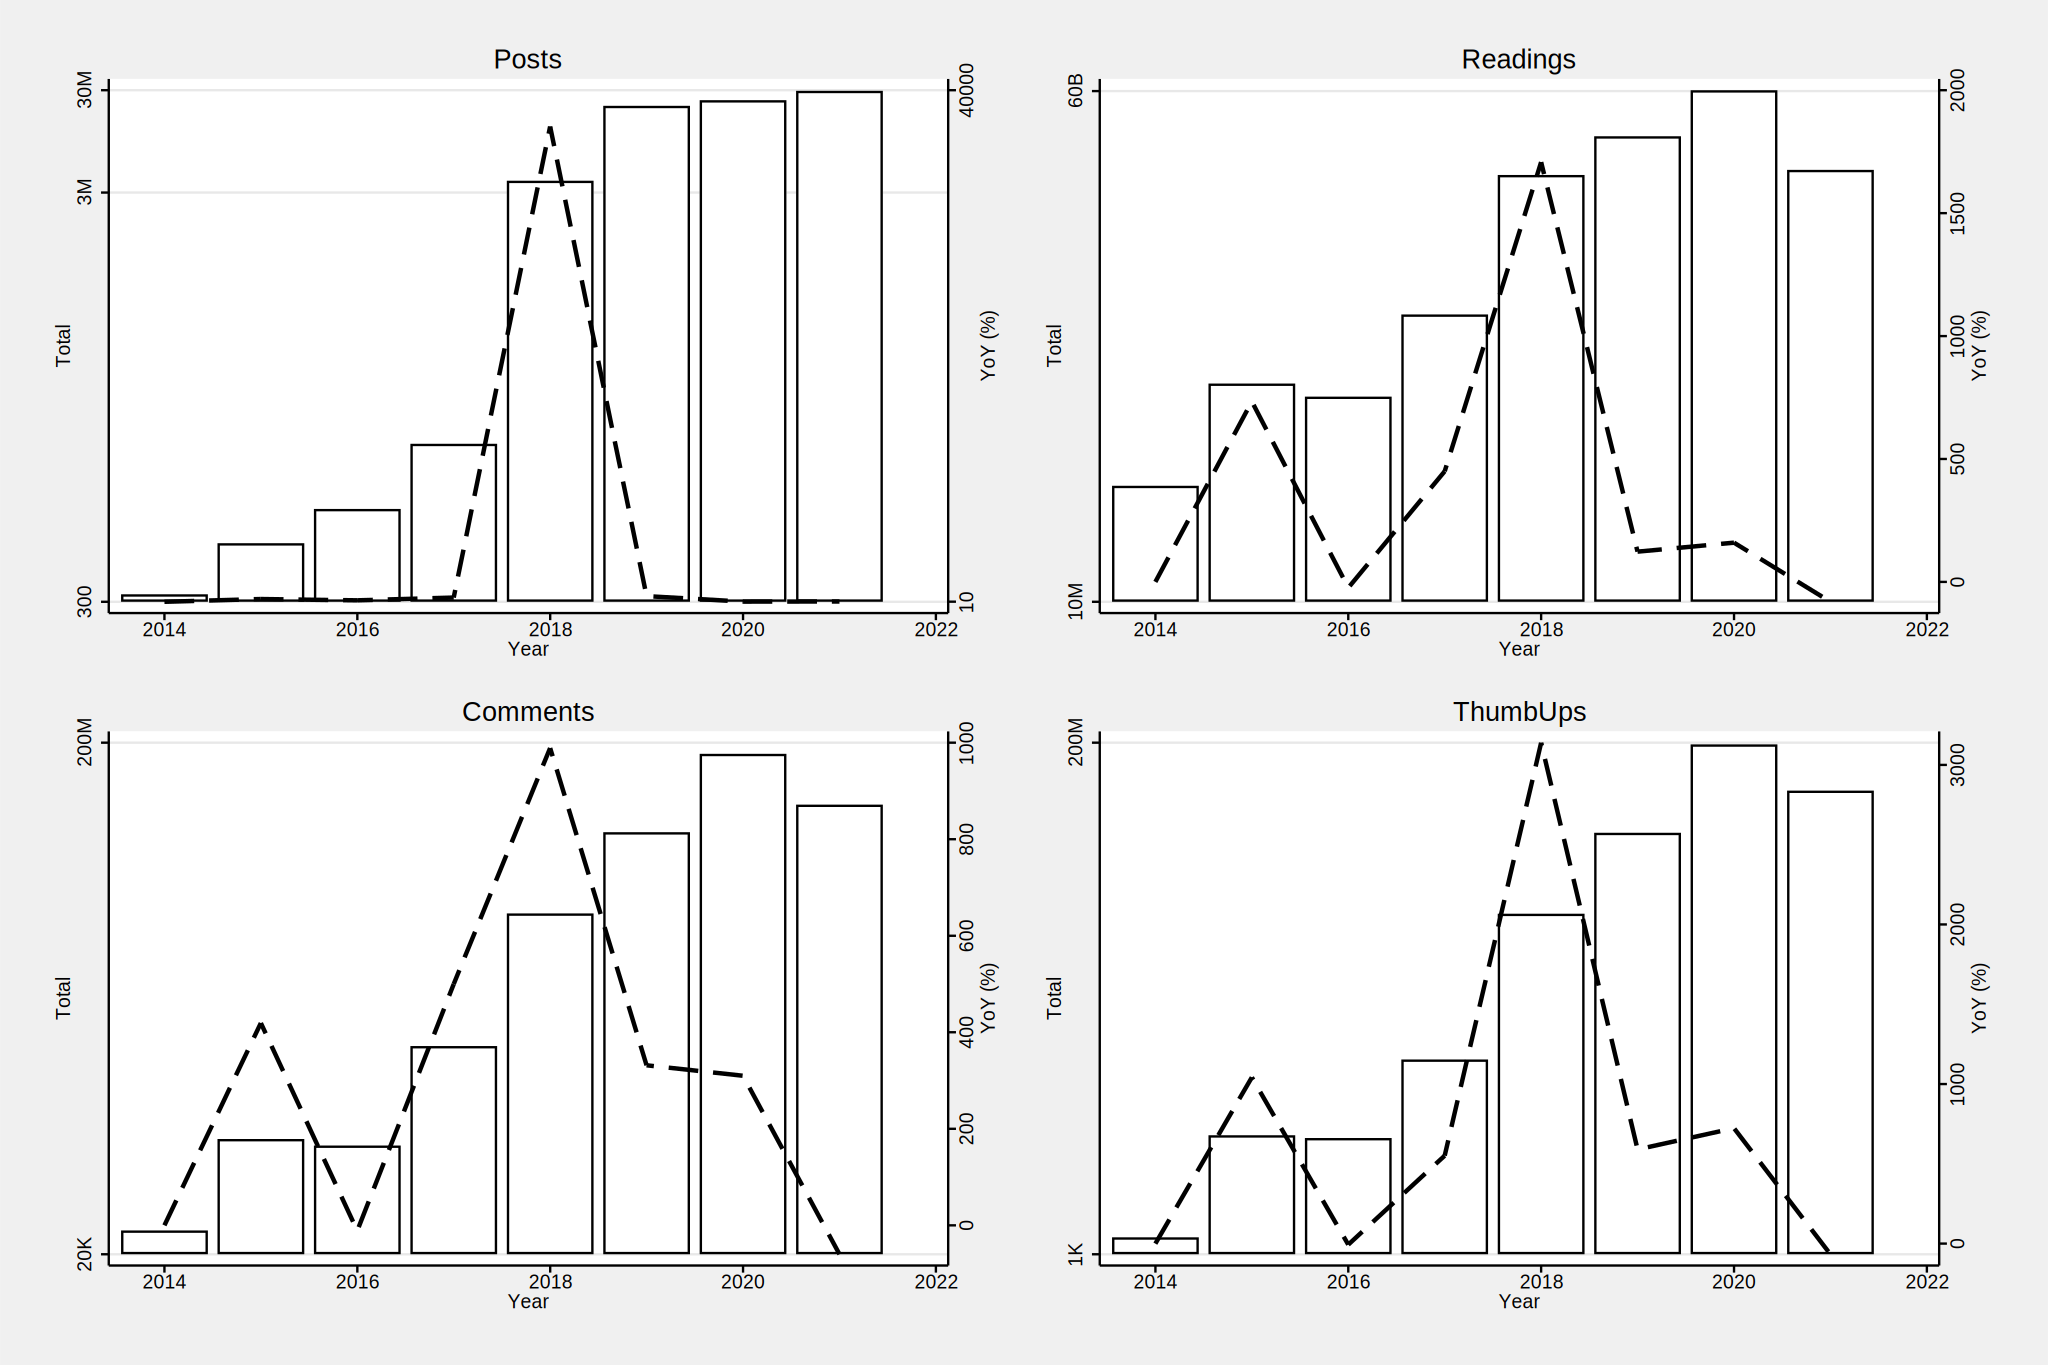

In [15]:
%%stata  -gw 12in -gh 8in -qui
graph combine Posts Readings Comments ThumbUps , name(Attention,replace)  scale(0.5) scheme(sj)
graph export Investor-Sentiment/outputs/imgs/forum_attention.svg ,replace

股吧情绪时间序列和分布


. graph combine time_change distribution, name(c2,replace) scale(0.5)  scheme(s
> j)

. graph export Investor-Sentiment/outputs/imgs/forum_sent.svg ,replace
(file Investor-Sentiment/outputs/imgs/forum_sent.svg not found)
file Investor-Sentiment/outputs/imgs/forum_sent.svg saved as SVG format

. 


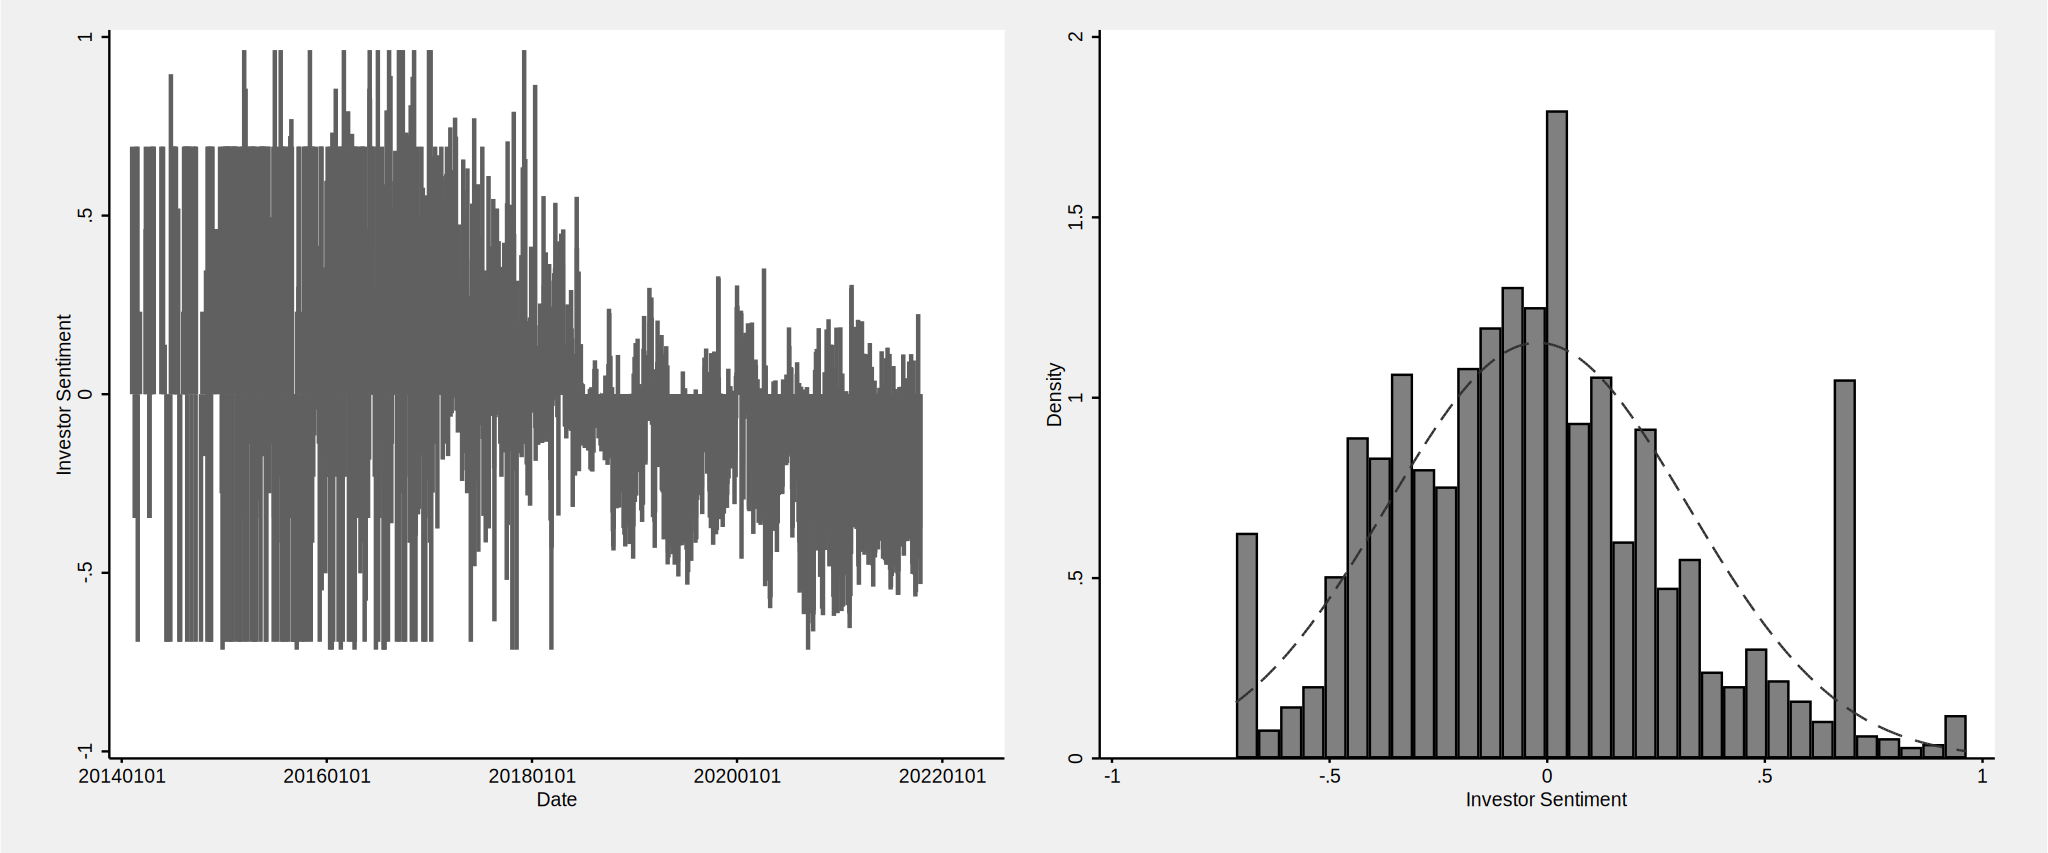

In [27]:
%%stata -gw 12in -gh 5in
graph combine time_change distribution, name(c2,replace) scale(0.5)  scheme(sj)
graph export Investor-Sentiment/outputs/imgs/forum_sent.svg ,replace

### 线性回归分析-发布日期

#### 模型设定

In [17]:
%%stata -d df_ols_pdate -force -qui
//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 IndexA IndexB Posts Readings Comments ThumbUps NegPosts NeuPosts PosPosts, cut(1 99)  replace
winsor2 Age, cut(1 100) trim replace

//外生变量
ge dt = date(p_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)

//生成变量
ge img_pos=1-img_neg

//变量对数处理
ge NonNegRatio=1-NegRatio
foreach var in Posts Readings Comments ThumbUps NegPosts NeuPosts PosPosts {
    ge ln`var'=ln(`var')
}

#### 基准回归
!查看基准回归结果

In [18]:
%%stata

//清除
est clear

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (tex_neg)

//显示固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_base.rtf ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSent B" "InvestorSent A" "InvestorSent B") ///
mgroups("img_neg" "tex_neg", pattern(1 0 1 0 )) ///
nogaps  b(%12.4f)


. 
. //清除
. est clear

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est2 stored)

. rename(media_neg) (img_neg)

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est3 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est4 stored)

. rename(media_neg) (tex_neg)

. 
. //显示固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_base.rtf ,r type //
> /
> keep(L.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSen
> t B" "InvestorSent A" "InvestorSent B") ///
> 

#### 注意力效应回归
媒体情绪通过投资者关注度,影响投资者情绪

In [19]:
%%stata
//清除
est clear

//图像情绪回归
eststo: qui reg IndexB L.lnPosts L.img_neg i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.lnReadings#c.L.img_neg i.year,r
eststo: qui reg IndexB L.lnPosts c.L.lnComments#c.L.img_neg i.year,r
eststo: qui reg IndexB L.lnPosts c.L.lnThumbUps#c.L.img_neg i.year,r

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_attention.rtf ,r type ///
keep(*L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Attention") ///
nogaps compress b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归
. eststo: qui reg IndexB L.lnPosts L.img_neg i.year ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnReadings#c.L.img_neg i.year,r
(est2 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnComments#c.L.img_neg i.year,r
(est3 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnThumbUps#c.L.img_neg i.year,r
(est4 stored)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_attention.rtf ,r ty
> pe ///
> keep(*L.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Attention") ///
> nogaps compress b(%12.4f)

{\rtf1\ansi\deff0 {\fonttbl\f0\fnil Times New Roman;}
{\info {\author .}{\company .}{\title .}{\creatim\yr2022\mo12\dy25\hr14\min31}}
\deflang1033\plain\fs24
{\footer\pard\qc\plain\f0\fs24\chpgn\par}
{\pard\keepn\ql Table Investor Attention\par}
{
{\trowd\trgaph108\trleft-108\clbrdrt\brdrw10\brdrs\cellx1308\clbrdrt\b

#### 情绪非对称效应回归

In [20]:
%%stata
//清除
est clear

//图像情绪回归 积极,消极和中立的异质影响
eststo: qui reg IndexB L.lnPosts L.img_neg  i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegDummy  i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.PosDummy  i.year ,r

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_nonsymmetry.rtf ,r type ///
keep(*L*.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Non-symmetry") ///
nogaps b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归 积极,消极和中立的异质影响
. eststo: qui reg IndexB L.lnPosts L.img_neg  i.year ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegDummy  i.year ,r
(est2 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.PosDummy  i.year ,r
(est3 stored)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_nonsymmetry.rtf ,r 
> type ///
> keep(*L*.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Non-symmetry") ///
> nogaps b(%12.4f)
(file Investor-Sentiment/outputs/media_to_investor_nonsymmetry.rtf not found)

{\rtf1\ansi\deff0 {\fonttbl\f0\fnil Times New Roman;}
{\info {\author .}{\company .}{\title .}{\creatim\yr2022\mo12\dy25\hr14\min31}}
\deflang1033\plain\fs24
{\footer\pard\qc\plain\f0\fs24\chpgn\par}
{\pard\keepn\ql Table Investor Non-symmetry\par}
{
{\trowd\trgaph108\trleft-108\clbrdrt\brdrw10\brdrs\cellx1548\cl

#### 年龄异质性回归(不稳健)

In [21]:
%%stata
//清除
est clear

//图像情绪回归 按年龄分组
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts  i.year if Age<3.151351 ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year if Age<3.151351 ,r

eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151351 ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.151351 ,r

eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151351 ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.151351 ,r

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果//
esttab using Investor-Sentiment/outputs/media_to_investor_age ,r type ///
keep(*L*.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Age") ///
mgroups("Low Age" "High Age", pattern(1 0 1 0 )) ///
nogaps b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归 按年龄分组
. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts  i.year if Age<3.151
> 351 ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year if Age<3.15
> 1351 ,r
(est2 stored)

. 
. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151
> 351 ,r
(est3 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.15
> 1351 ,r
(est4 stored)

. 
. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151
> 351 ,r
(est5 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.15
> 1351 ,r
(est6 stored)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果//
. esttab using Investor-Sentiment/outputs/media_to_investor_age ,r type ///
> keep(*L*.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Age") ///
> mgroups("Low Age" "High Age", pattern(1 0 1 0 )) /

 ### 线性回归分析-交易日期

#### 模型设定 -t

In [22]:
%%stata -d df_ols_tdate -force -qui
//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 IndexA IndexB Posts Readings Comments ThumbUps NegPosts NeuPosts PosPosts, cut(1 99)  replace

//外生变量
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)

//生成变量
ge img_pos=1-img_neg

//变量对数处理
foreach var in Posts Readings Comments ThumbUps NegPosts NeuPosts PosPosts {
    ge ln`var'=ln(`var')
}

#### 基准回归 -t

In [23]:
%%stata

//清除
est clear

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (tex_neg)

//显示固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_base ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSent B" "InvestorSent A" "InvestorSent B") ///
mgroups("img_neg" "tex_neg", pattern(1 0 1 0 )) ///
nogaps  b(%12.4f)


. 
. //清除
. est clear

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est2 stored)

. rename(media_neg) (img_neg)

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est3 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est4 stored)

. rename(media_neg) (tex_neg)

. 
. //显示固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_base ,r type ///
> keep(L.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSen
> t B" "InvestorSent A" "InvestorSent B") ///
> mgroups

## 4.投资者情绪对股票市场的影响

In [24]:
# %%stata -d df_var -force
# est clear
#
# //设定面板数据
# encode ts_code,gen(id)
# xtset id time
#
# //增加固定效应
# ge dt = date(trade_date, "YMD")
# format dt %tdCCYYNNDD
# ge year=year(dt)
#
# //增加平方项
# ge close_chg_s=close_chg*close_chg
#
# //分组VAR回归
# by id, sort : eststo: qui var close_chg IndexB close_chg_s, lags(1/5) exog(year)
#
# esttab , keep(close_chg:L*.IndexB) nogaps compress b(%12.4f) star(* 0.1 ** 0.05 *** 0.01)

## 弃用代码

### 发布日情绪(弃用)

### 合并和映射(弃用)

In [25]:
def cal_investor_sentiment_pdate_old(df: cudf.DataFrame, a, b, c, d) -> cudf.DataFrame:
    """
    计算加权投资者情绪,旧的版本
    """

    # 每日总量
    df['DayTotalPosts'] = df.groupby(['PostDate', ])['TotalPosts'].transform('sum')
    df['DayAvgReadings'] = df.groupby(['PostDate', ])['AvgReadings'].transform('sum')
    df['DayAvgComments'] = df.groupby(['PostDate', ])['AvgComments'].transform('sum')
    df['DayAvgPositThumbUps'] = df.groupby(['PostDate', ])['AvgPositThumbUps'].transform('sum')

    # 加权因子总量
    df['DayTotalPostsFactor'] = df['TotalPosts'] / df['DayTotalPosts']
    df['DayAvgReadingsFactor'] = df['AvgReadings'] / df['DayAvgReadings']
    df['DayAvgCommentsFactor'] = df['AvgComments'] / df['DayAvgComments']
    df['DayAvgPositThumbUpsFactor'] = df['AvgPositThumbUps'] / df['DayAvgPositThumbUps']

    # 个股加权情绪因子
    df['PositiveSentIndexAFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexA']
    )

    df['PositiveSentIndexBFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexB']
    )

    # 每日情绪因子
    df['DayPositiveSentIndexA'] = df.groupby(['PostDate'])['PositiveSentIndexAFactor'].transform('sum')
    df['DayPositiveSentIndexB'] = df.groupby(['PostDate'])['PositiveSentIndexBFactor'].transform('sum')

    # 转换为时间序列数据
    df_time = df.groupby(['PostDate', ], as_index=False).first()[
        ['PostDate', 'DayPositiveSentIndexA', 'DayPositiveSentIndexB',
         'DayTotalPosts', 'DayAvgReadings', 'DayAvgComments', 'DayAvgPositThumbUps']]
    df_time.columns = ['p_date', 'IndexA', 'IndexB', 'Posts', 'Readings', 'Comments', 'ThumbUps']
    return df_time

# cal_investor_sentiment(df_forum, A, B, C, D)

In [26]:
def merge_tdate_media_investor_ex(ex_coff) -> cudf.DataFrame:
    """
    考虑了衰减系数
    :return:
    """
    df_map = cudf.merge(
            cal_investor_sentiment(df_forum, A2, B2, C2, D2),
            extract_map_date(),
            on=['p_date'], how='left'

    ).set_index(['trade_date', 'p_date']).sort_index().reset_index()

    # 计算序号
    df_map['distance'] = df_map.groupby('trade_date')['p_date'].rank()

    # 指数化衰减
    df_map['distance_ex'] = np.exp(df_map['distance'] / ex_coff)
    df_map['ex_total'] = df_map.groupby('trade_date')['distance_ex'].transform('sum')
    df_map['ex_factor'] = df_map['distance_ex'] / df_map['ex_total']

    # 衰减
    df_map = df_map.set_index(['trade_date', 'p_date'])
    for col in df_map.columns: df_map[col] = df_map[col] * df_map['ex_factor']
    df_map = df_map.reset_index()

    # 计算平均指标 这里应该要衰减
    df_map['IndexA'] = df_map.groupby('trade_date', as_index=False)['IndexA'].transform('mean')
    df_map['IndexB'] = df_map.groupby('trade_date', as_index=False)['IndexB'].transform('mean')
    df_map['Posts'] = df_map.groupby('trade_date', as_index=False)['Posts'].transform('mean')
    df_map['Readings'] = df_map.groupby('trade_date', as_index=False)['Readings'].transform('mean')
    df_map['Comments'] = df_map.groupby('trade_date', as_index=False)['Comments'].transform('mean')
    df_map['ThumbUps'] = df_map.groupby('trade_date', as_index=False)['ThumbUps'].transform('mean')

    # 时间序列
    df_map = df_map.groupby('trade_date').first().sort_index().reset_index()

    # 合并
    df_merge = cudf.merge(Loader().get_time_series().reset_index(), df_map, on='trade_date', how='left')

    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    return df_merge.set_index('trade_date').sort_index().reset_index()


def merge_tdate_media_investor() -> cudf.DataFrame:
    """
    合并论坛和媒体情绪,交易日期
    """
    df_map = cudf.merge(
            cal_investor_sentiment(df_forum, A2, B2, C2, D2),
            extract_map_date(),
            on=['p_date'], how='left'

    )

    # 计算平均指标 这里应该要衰减
    df_map['IndexA'] = df_map.groupby('trade_date', as_index=False)['IndexA'].transform('mean')
    df_map['IndexB'] = df_map.groupby('trade_date', as_index=False)['IndexB'].transform('mean')
    df_map['Posts'] = df_map.groupby('trade_date', as_index=False)['Posts'].transform('mean')
    df_map['Readings'] = df_map.groupby('trade_date', as_index=False)['Readings'].transform('mean')
    df_map['Comments'] = df_map.groupby('trade_date', as_index=False)['Comments'].transform('mean')
    df_map['ThumbUps'] = df_map.groupby('trade_date', as_index=False)['ThumbUps'].transform('mean')

    # 时间序列
    df_map = df_map.groupby('trade_date').first().sort_index().reset_index()

    # 合并
    df_merge = cudf.merge(Loader().get_time_series().reset_index(), df_map, on='trade_date', how='left')

    return df_merge.set_index('trade_date').sort_index().reset_index()


def merge_pdate_media_investor() -> cudf.DataFrame:
    """
    发布日期定义的合并
    :return:
    """
    # 合并
    df_merge = cudf.merge(extract_pdate_mediasent(), cal_investor_sentiment(df_forum, A, B, C, D), on='p_date',
                          how='left')

    # 改名字方便变量
    return df_merge.rename(columns={'p_date': 'trade_date'}).set_index('trade_date').sort_index().reset_index()